In [1]:
import tensorflow as tf
import numpy as np
import pylab as plt
import tensorflow_probability as tfp
tfd = tfp.distributions
from seaborn import pairplot,jointplot
import pandas as pd
plt.style.use('ggplot')

/home/albert/miniconda3/envs/tectf/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/albert/miniconda3/envs/tectf/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In [2]:
freqs = np.linspace(120e6,160e6,20)
tec_conversion = -8.448e9/freqs
true_tec = np.array([0.04])
noise_rads = 0.3# a lot of noise on almost flat TEC is hard
true_phase = true_tec[...,None] * tec_conversion
phase = true_phase + noise_rads*np.random.normal(size=true_phase.shape)


def wrap(phi):
    return tf.atan2(tf.sin(phi),tf.cos(phi))

def log_normal_solve(mean,std):
    mu = np.log(mean) - 0.5*np.log((std/mean)**2 + 1)
    sigma = np.sqrt(np.log((std/mean)**2 + 1))
    return mu, sigma

with tf.Session(graph=tf.Graph()) as sess:
    x = tf.placeholder(tf.float64,shape=true_phase.shape)
    tec = 0.01*tf.get_variable('tec',shape=true_phase.shape[:-1],dtype=tf.float64,initializer=tf.zeros_initializer())
    log_sigma = tf.get_variable('log_sigma',trainable=True,shape=true_phase.shape[:-1],dtype=tf.float64,initializer=tf.zeros_initializer())
    sigma = 0.3*tf.exp(log_sigma)
    mu = tec[...,None]*tf.convert_to_tensor(tec_conversion,dtype=tf.float64)
    d = tf.stack([tfd.Normal(wrap(mu) + k*2*np.pi, sigma[:,None]).log_prob(wrap(x)) for k in range(-2,3,1)], axis=0)
    
    log_prob = tf.reduce_logsumexp(d, axis=0)
    
    sigma_prior = log_normal_solve(0.25,0.25)
    prior = tf.reduce_sum(tfd.Normal(tf.convert_to_tensor(0.,dtype=tf.float64),
                                     tf.convert_to_tensor(0.5,dtype=tf.float64)).log_prob(tec)) \
        + tf.reduce_sum(tfd.LogNormal(tf.convert_to_tensor(sigma_prior[0],dtype=tf.float64), 
                                      tf.convert_to_tensor(sigma_prior[1],dtype=tf.float64)).log_prob(sigma))
    
    loss = -tf.reduce_sum(log_prob) - prior / tf.cast(tf.size(x),tf.float64)
    
    global_step = tf.Variable(0, trainable=False)
    starter_learning_rate = 0.3
    end_learning_rate = 1e-4
    decay_steps = 100
    learning_rate = tf.train.polynomial_decay(starter_learning_rate,
                                              global_step, decay_steps,
                                              end_learning_rate, power=1.)
    # Set up the optimizer
    optimizer_kernel = tfp.optimizer.StochasticGradientLangevinDynamics(
        learning_rate=learning_rate, preconditioner_decay_rate=0.95,)
#     optimizer_kernel = tfp.optimizer.VariationalSGD(1,tf.size(x),1e-5)
    optimizer = optimizer_kernel.minimize(loss)
    init = tf.global_variables_initializer()
    # Number of training steps
    training_steps = 200
    # Record the steps as and treat them as samples
    tec_samples = np.zeros((training_steps,) + true_tec.shape)
    sigma_samples = np.zeros((training_steps,) + true_tec.shape)
    losses =[]
    sess.run(init)
    for step in range(training_steps):
        _, loss_ = sess.run([optimizer, loss], feed_dict={x:phase})
        losses.append(loss_)
        tec_, sigma_ = sess.run([tec, sigma])
        tec_samples[step,:] = tec_
        sigma_samples[step,:] = sigma_
        if step % 50 == 0:
            print("{} loss {}".format(step,loss_))

    

0 loss 716.8123313500357
50 loss 20.845326556181334
100 loss 7.521598960745561
150 loss 3.994128025253311


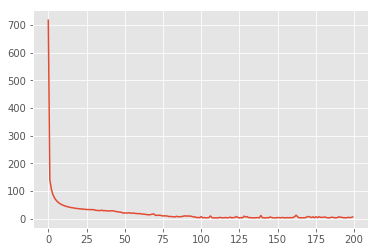

In [3]:
plt.plot(losses)
plt.show()

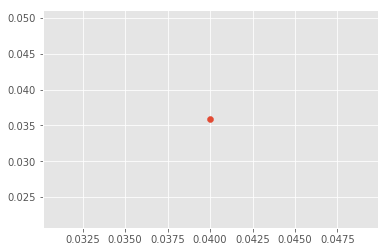

In [4]:
plt.scatter(true_tec,tec_samples.mean(0))
plt.show()

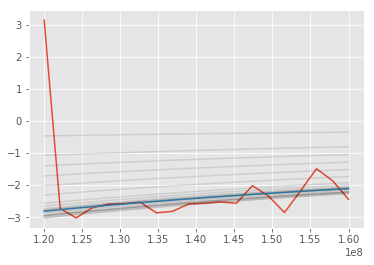

In [5]:
def w(phi):
    return np.angle(np.exp(1j*phi))

plt.plot(freqs,w(phase[0,:]))
plt.plot(freqs,w(true_phase[0,:]))
[plt.plot(freqs,w(t*tec_conversion),alpha=0.1,c='k') for t in tec_samples[::10,0]]
plt.show()

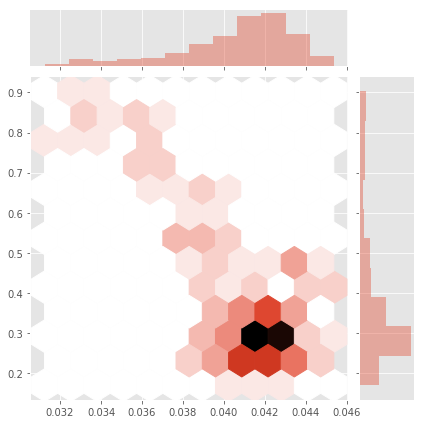

/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/matplotlib/contour.py:1004: UserWarning: The following kwargs were not used by contour: 'marker'
  s)


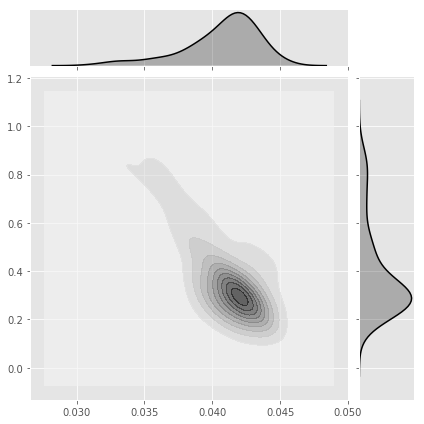

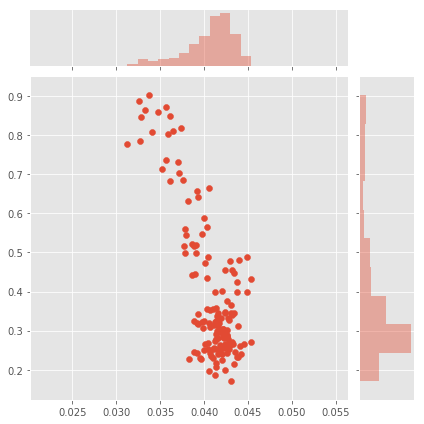

In [6]:
jointplot(tec_samples[50:,:],sigma_samples[50:,:],kind='hex')
plt.show()
jointplot(tec_samples[50:,:],sigma_samples[50:,:],kind='kde',alpha=0.6,marker='+',color='k')
plt.show()
jointplot(tec_samples[50:,:],sigma_samples[50:,:])
plt.show()